**Pregunta 1:** (Teorema 38.1 Trefethen and Bau) Considere la versión de Gradiente
Conjugado presentada en *Numerical Linear Algebra*. Demuestre que en cada paso 
$n$ del algoritmo (siempre que este no haya terminado) se cumple lo siguiente:

* $\mathcal{K}_n$ = span $\{x_1, ..., x_n\}$ = span $\{p_0, ..., p_{n-1}\}$ = 
span $\{r_0, ..., r_{n-1}\}$ = span $\{b, Ab, ..., A^{n-1}b\}$
* $r_n^Tr_j = 0, \quad (j<n)$
* $p_n^TAp_j = 0, \quad (j<n)$.

**Pregunta 2:** (Teorema 38.2 Trefethen and Bau) Demuestre que en cada 
paso $n$ de Gradiente Conjugado (siempre que no haya terminado antes) $x_n$ es 
el único minimizador del error $\|e_n\|_A = \|x_*-x_n\|_A$ en el espacio 
$\mathcal{K}_n$. Demuestre que 

$$\|e_n\|_A \leq \|e_{n-1}\|_A$$

y que $\|e_n\| = 0$ para algún $n \leq m$.

**Pregunta 3: Ejemplo CG Trefethen and Bau**

Consideramos una matriz $A \in \mathbb{R}^{500 \times 500}$, simétrica, de la 
siguiente forma:

$$
A = \begin{bmatrix}
    1 & \times & 0 & 0 & \times & \dots & 0\\
    \times & 1 & 0 & \times & 0 & \dots & \times \\
    0 & 0 & 1 & \times & \times & \dots & 0\\
    0 & \times & \times & 1 & 0 & \dots & \times\\
    \times & 0 & \times & 0 & 1 & \dots & 0\\
    \vdots & \vdots & \vdots & \vdots & \vdots& \ddots & \vdots\\
    0 & \times & 0 & \times & 0 & \dots & 1
\end{bmatrix}
$$

Donde las entradas $\times$ son distribuidas de manera uniforme en el intervalo 
$[-\tau, \tau]$, donde $\tau$ es una tolerancia dada. Además, las entradas 
no-cero $\times$ se eligen de tal forma que la densidad de entradas no-cero 
es aproximadamente $\tau$. La matriz $A$ se puede generar de la siguiente 
forma:  

In [1]:
import numpy as np
import scipy.sparse as sps

def A_CG(tau):

    data = []
    row = []
    col = []

    # para obtener los mismos resultados en cada ejecución, fijamos el rng
    np.random.seed(100)

    n = 500
    for idxj in range(n):
        for idxk in range(idxj):
            # random value
            val = -1 + 2*np.random.rand()
            if abs(val) < tau:
                # data update
                data.append(val)
                row.append(idxj)
                col.append(idxk)

                # add matrix symmetry
                data.append(val)
                row.append(idxk)
                col.append(idxj)
    
    A_triang = sps.coo_matrix((data, (row, col)), (n, n))
    A_triang = sps.csr_matrix(A_triang)
    A = sps.eye(n) + A_triang

    return A

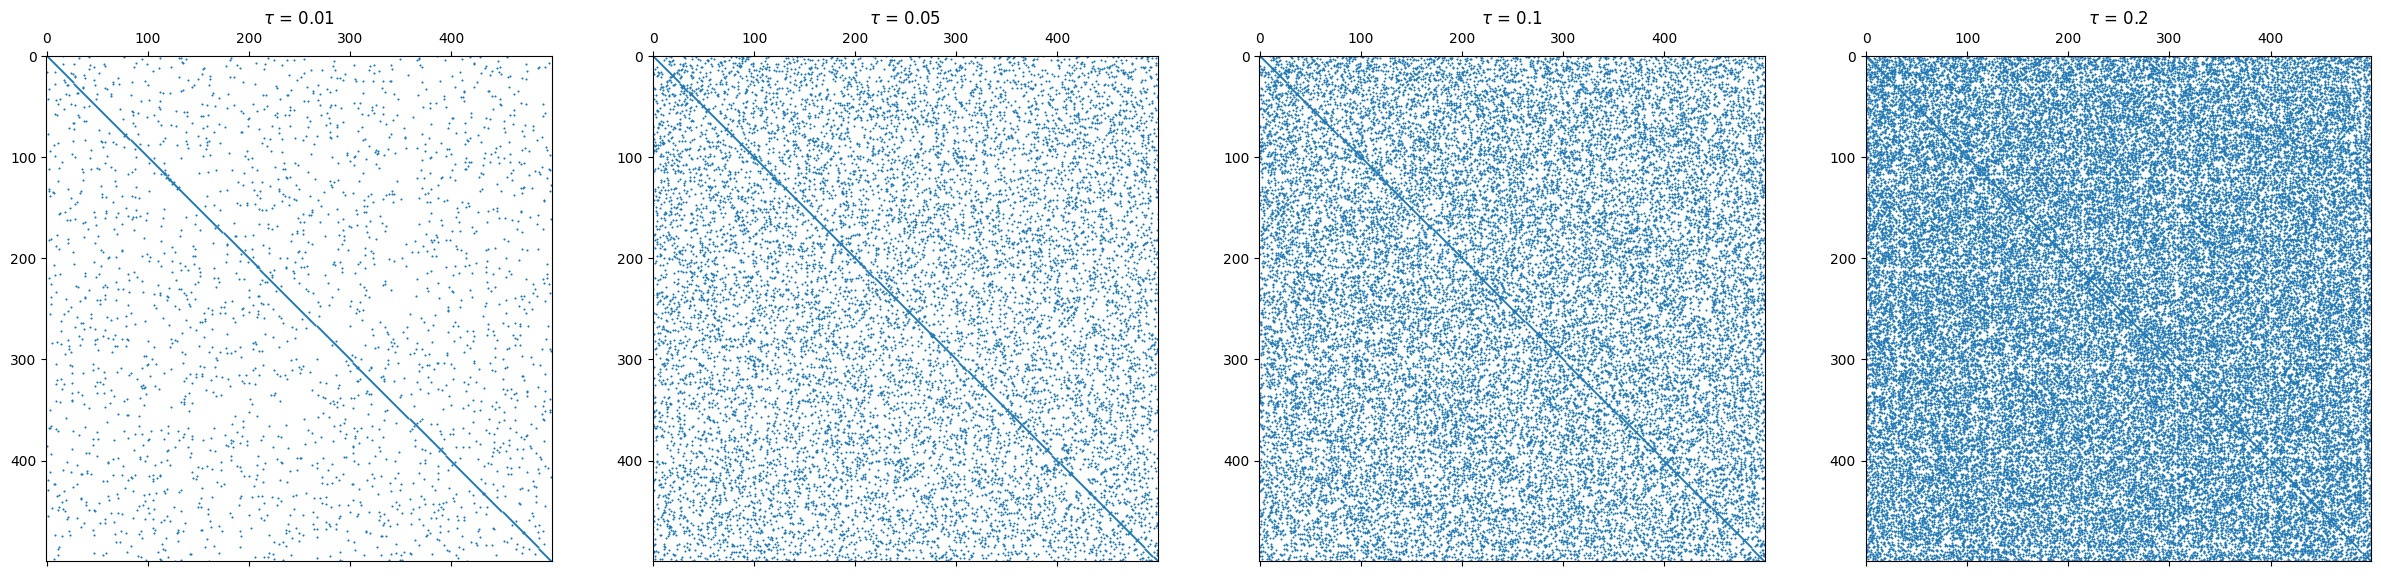

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
axs[0].set_title(r"$\tau$ = 0.01")
axs[0].spy(A_CG(0.01), markersize=0.5)
axs[1].set_title(r"$\tau$ = 0.05")
axs[1].spy(A_CG(0.05), markersize=0.5)
axs[2].set_title(r"$\tau$ = 0.1")
axs[2].spy(A_CG(0.1), markersize=0.5)
axs[3].set_title(r"$\tau$ = 0.2")
axs[3].spy(A_CG(0.2), markersize=0.5)

In [11]:
np.linalg.det(A_CG(0.02).toarray())

0.723242341590077

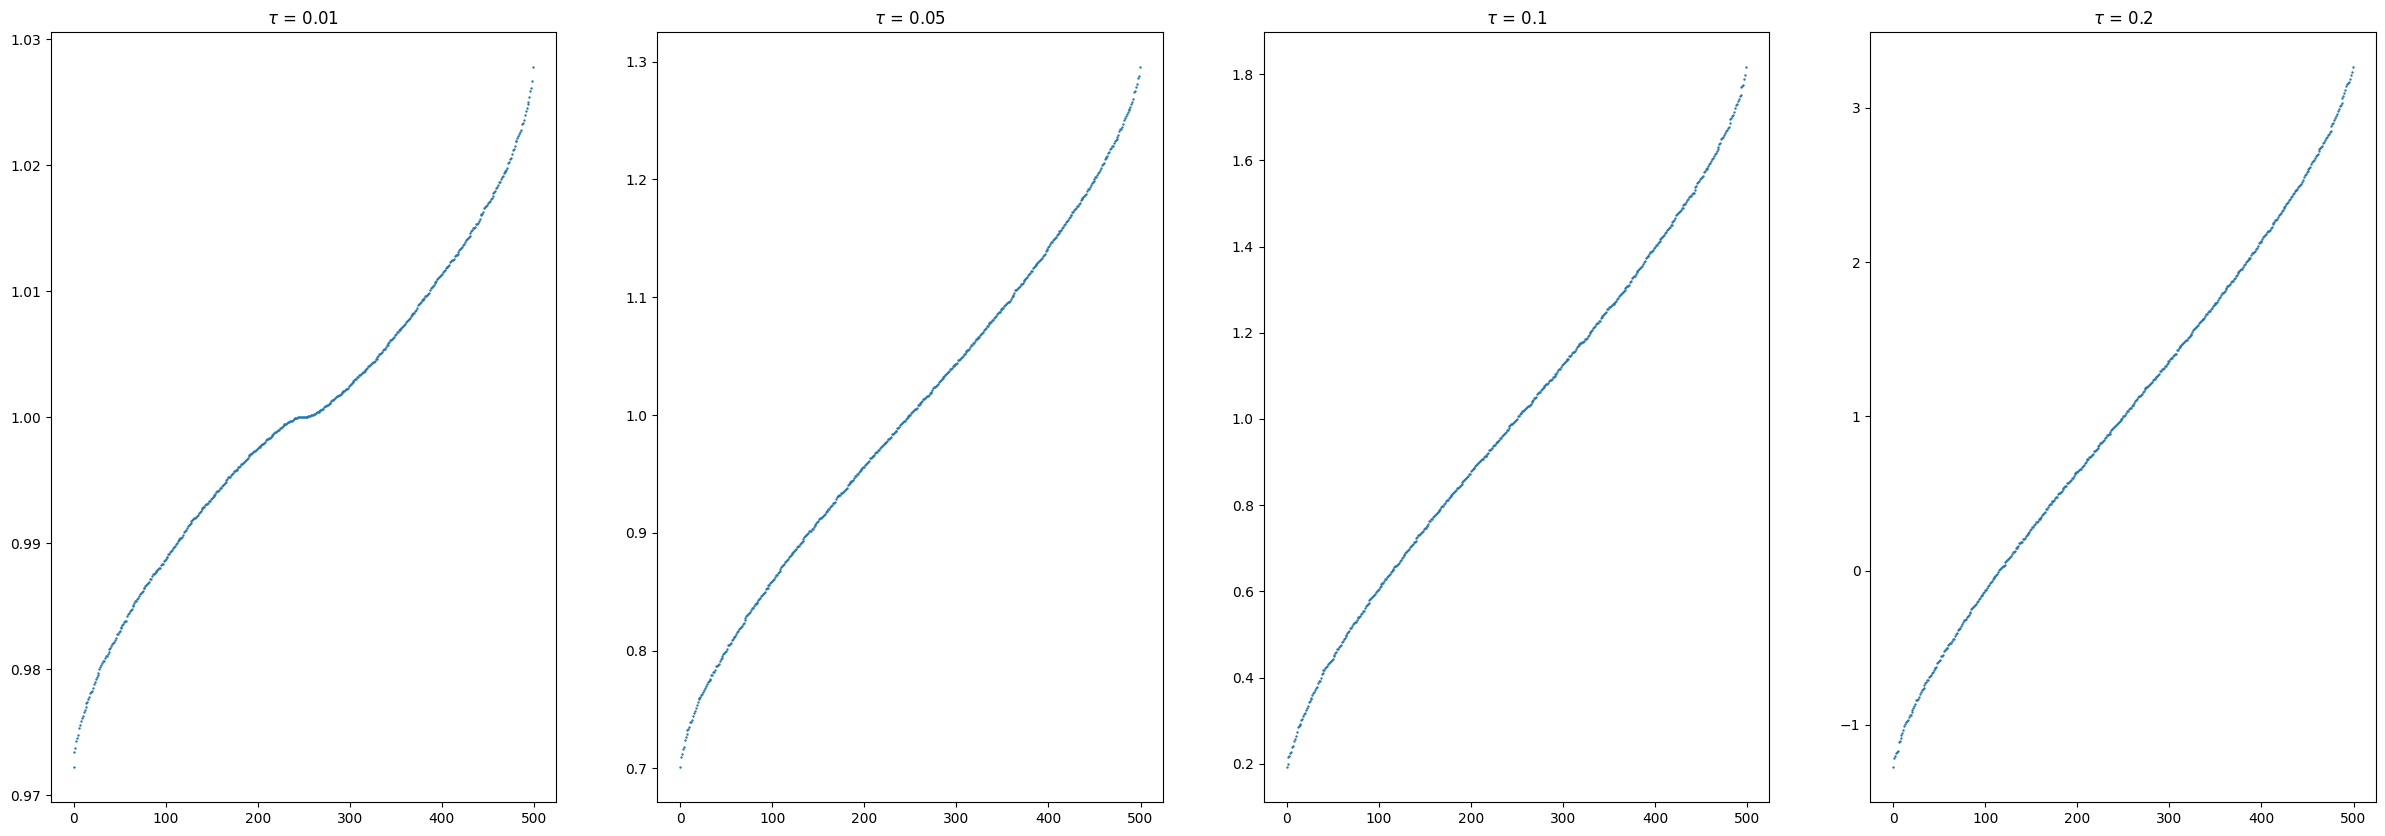

In [3]:
import scipy.sparse.linalg as spsl

n = 500

eigs1 = sorted(np.linalg.eigvals(A_CG(0.01).todense()))
eigs2 = sorted(np.linalg.eigvals(A_CG(0.05).todense()))
eigs3 = sorted(np.linalg.eigvals(A_CG(0.1).todense()))
eigs4 = sorted(np.linalg.eigvals(A_CG(0.2).todense()))

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
axs[0].set_title(r"$\tau$ = 0.01")
axs[0].scatter(list(range(len(eigs1))), eigs1, s=0.5)
axs[1].set_title(r"$\tau$ = 0.05")
axs[1].scatter(list(range(len(eigs2))), eigs2, s=0.5)
axs[2].set_title(r"$\tau$ = 0.1")
axs[2].scatter(list(range(len(eigs3))), eigs3, s=0.5)
axs[3].set_title(r"$\tau$ = 0.2")
axs[3].scatter(list(range(len(eigs4))), eigs4, s=0.5)

In [4]:
print("Condicionamiento tau=0.01:", np.linalg.cond(A_CG(0.01).todense()))
print("Condicionamiento tau=0.05:", np.linalg.cond(A_CG(0.05).todense()))
print("Condicionamiento tau=0.1:", np.linalg.cond(A_CG(0.1).todense()))
print("Condicionamiento tau=0.2:", np.linalg.cond(A_CG(0.2).todense()))

Condicionamiento tau=0.01: 1.0571352905214388
Condicionamiento tau=0.05: 1.8481994936126647
Condicionamiento tau=0.1: 9.467952707195067
Condicionamiento tau=0.2: 1213.1451127801902


Text(0, 0.5, '$\\| r \\|$')

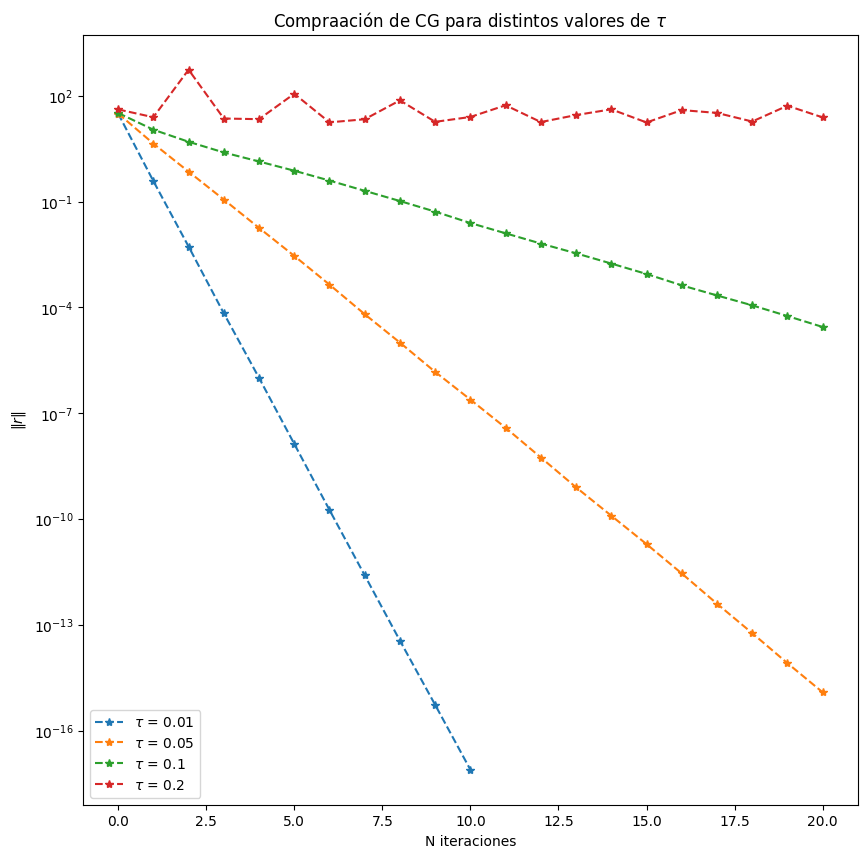

In [5]:
def cg_method(A, b, x0, j_max=1000, tol=1e-10):
    # j-esima estimacion de CG
    m, n = A.shape
    xj = x0
    j = 0
    pj = b-A.dot(xj)
    rj = pj
    errs = [np.linalg.norm(rj)]
    while (np.linalg.norm(rj) > tol) and (j<j_max):
        tj = A.dot(pj)
        muj = (np.linalg.norm(rj)**2)/np.dot(tj, pj)
        xj = xj + muj*pj
        rj = rj - muj*tj
        bj = (np.linalg.norm(rj)**2)/(np.linalg.norm(rj+muj*tj)**2)
        pj = rj+bj*pj
        errs.append(np.linalg.norm(rj))
        j += 1
    return xj, j, pj, errs

b = np.random.randn(n)
x0 = np.random.randn(n)
_, _, _, errs1 = cg_method(A_CG(0.01), b, x0, j_max=20, tol=1e-16)
_, _, _, errs2 = cg_method(A_CG(0.05), b, x0, j_max=20, tol=1e-16)
_, _, _, errs3 = cg_method(A_CG(0.1), b, x0, j_max=20, tol=1e-16)
_, _, _, errs4 = cg_method(A_CG(0.2), b, x0, j_max=20, tol=1e-16)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_yscale("log")
ax.plot(errs1, "--*", label=r"$\tau$ = 0.01")
ax.plot(errs2, "--*", label=r"$\tau$ = 0.05")
ax.plot(errs3, "--*", label=r"$\tau$ = 0.1")
ax.plot(errs4, "--*", label=r"$\tau$ = 0.2")
ax.legend()
ax.set_title(r"Compraación de CG para distintos valores de $\tau$")
ax.set_xlabel("N iteraciones")
ax.set_ylabel(r"$\| r \|$")

**Pregunta 4:**

La convergencia para steepest descent viene dada por la siguiente fórmula:

$$
\|x^*-x_j\|_A \leq \left(1 - \frac{1}{\kappa_2(A)}\right)^{j/2} \|x^*-x_0\|_A,
$$

mientras que para gradientes conjugados la estimación viene dada por:

$$
\|x^*-x_j\|_A \leq 2\left(\frac{\sqrt{K_2(A)}-1}{\sqrt{K_2(A)}+1}\right)^{j/2} 
\|x^*-x_0\|_A
$$

In [6]:
def steepest_descent(A, b, x0=None, tol=1e-10, j_max=100):
    '''retorna xj, j, rj'''
    # j_max-esima aproximación de descenso mas rapido
    m, n = A.shape
    if x0 is None:
        x0 = np.zeros(n)
    xj = x0
    p = b-A.dot(x0)
    j = 0
    errs = [np.linalg.norm(p)]
    while (np.linalg.norm(p) > tol) and (j < j_max):
        a = np.dot(p, p)/np.dot(A.dot(p), p)
        xj = xj + a*p
        p = b-A.dot(xj)
        errs.append(np.linalg.norm(p))
        j += 1
    return xj, j, errs

def cg_method(A, b, x0, j_max=None, tol=1e-10):
    # j-esima estimacion de CG
    m, n = A.shape
    xj = x0
    j = 0
    pj = b-A.dot(xj)
    rj = pj
    errs = [np.linalg.norm(rj)]
    while (np.linalg.norm(rj) > tol) and (j<j_max):
        tj = A.dot(pj)
        aj = (np.linalg.norm(rj)**2)/np.dot(tj, pj)
        xj = xj + aj*pj
        rj = rj - aj*tj
        bj = (np.linalg.norm(rj)**2)/(np.linalg.norm(rj+aj*tj)**2)
        pj = rj+bj*pj
        errs.append(np.linalg.norm(rj))
        j += 1
    return xj, j, pj, errs

def sd_estimate(A, x0, xr, j):
    k = np.linalg.cond(A)
    factor = ((k-1)/(k+1))**j
    return factor*np.sqrt(np.dot(A.dot(xr-x0), xr-x0))

def cg_estimate(A, x0, xr, j):
    k = np.sqrt(np.linalg.cond(A))
    factor = 2*((k-1)/(k+1))**j
    return factor*np.sqrt(np.dot(A.dot(xr-x0), xr-x0))

A continuación se muestra que los errores para descenso de gradiente y 
gradientes conjugados se encuentran por debajo de las cotas respectivas:

Condicionamiento de A: 396.94202179984677


/var/folders/tk/2_mpyl8j60nc6pfc634c2mc80000gn/T/ipykernel_24127/2332141494.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


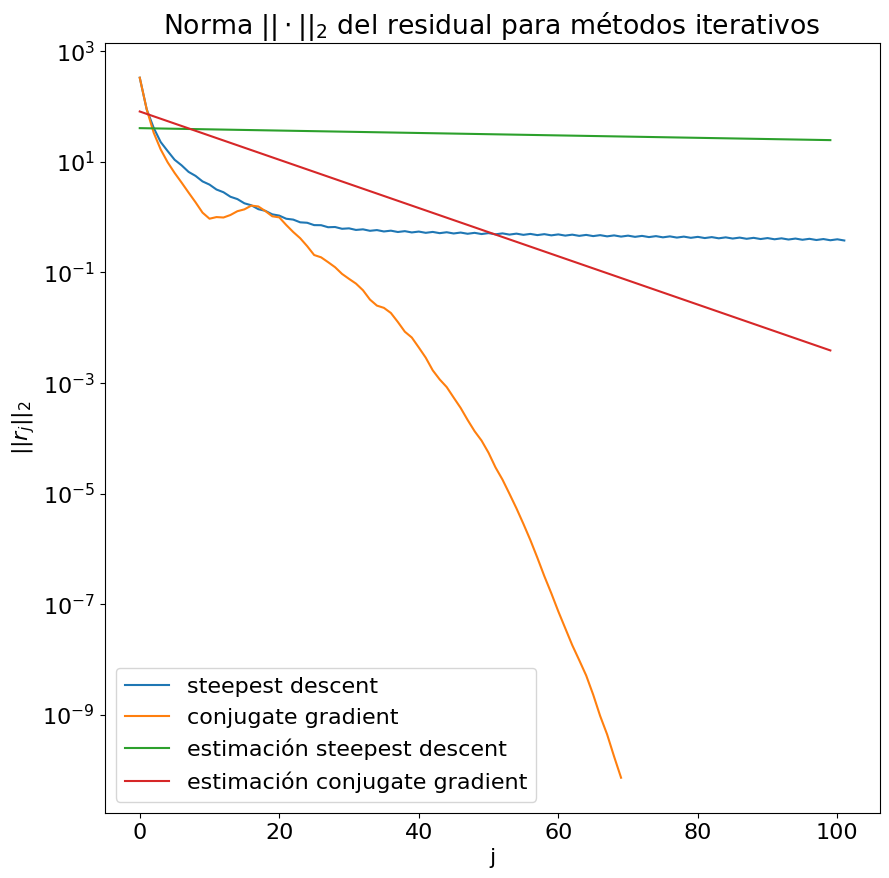

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def A_maker(n):
    # construye la matriz A del enunciado
    # 1,..., n en la diagonal principal
    diag = np.arange(1, n+1, 1, dtype=np.int64)
    # unos en las subdiagonales superior e inferior
    sub_diag = np.ones(n-1)
    A = np.diag(diag, 0) + np.diag(sub_diag, k=1) + np.diag(sub_diag, k=-1)
    return A

n = 100

A = A_maker(n)
b = np.ones(n)
xr = np.linalg.solve(A, b)
res_sd = np.zeros(n)
res_cg = np.zeros(n)
x0 = np.random.rand(n)
_, _, errsSD = steepest_descent(A, b, x0, j_max=n+1)
_, _, _, errsCG = cg_method(A, b, x0, j_max=n+1)
estimate_sd = [sd_estimate(A, x0, xr, j) for j in range(n)]
estimate_cg = [cg_estimate(A, x0, xr, j) for j in range(n)]

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(errsSD, label='steepest descent')
ax.plot(errsCG, label='conjugate gradient')
ax.plot(estimate_sd, label='estimación steepest descent')
ax.plot(estimate_cg, label='estimación conjugate gradient')
ax.set_yscale("log")
ax.set_xlabel('j')
ax.set_ylabel(r'$||r_j||_2$')
ax.set_title(r'Norma $||\cdot||_2$ del residual para métodos iterativos')
ax.legend()
print("Condicionamiento de A:", np.linalg.cond(A))
fig.show()